In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, AdamW

from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.utils import resample

sns.set_theme()

## Carregamento dos Dados
---

In [2]:
df = loadmat("ECGData.mat")['ECGData']
data, labels = df[0][0]

df = pd.DataFrame(data).round(4)
target = pd.Series([l[0][0] for l in labels])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,-0.0979,-0.1569,-0.1378,-0.1372,-0.1477,-0.1685,-0.1759,-0.1702,-0.1811,-0.1465,...,-0.1615,-0.1248,-0.1052,-0.0944,-0.1250,-0.1046,-0.1267,-0.0749,-0.1165,-0.1804
1,0.1194,0.1876,0.1696,0.1786,0.2118,0.1966,0.0729,0.1659,0.0832,0.1992,...,-0.1417,-0.1214,-0.1138,-0.0876,-0.0973,-0.0891,-0.1056,-0.0972,-0.1239,-0.1065
2,-0.0246,-0.0363,-0.0360,-0.0302,-0.0458,-0.0931,-0.0914,-0.1290,-0.1125,-0.1273,...,-0.3279,-0.3084,-0.2824,-0.2694,-0.2488,-0.2476,-0.1917,-0.1861,-0.1300,-0.1224
3,-0.5083,-0.8080,-0.7217,-0.7897,-0.7677,-0.7744,-0.7725,-0.7943,-0.7949,-0.7781,...,-0.9534,-0.9434,-0.9715,-0.9886,-0.9949,-0.9967,-1.0154,-1.0427,-1.0407,-1.0482
4,-0.3120,-0.4953,-0.4426,-0.4652,-0.4284,-0.4444,-0.4176,-0.4533,-0.4292,-0.4419,...,0.3921,0.4347,0.5235,0.5929,0.6630,0.7438,0.8094,0.8225,0.7872,0.6843


## Visualização
---

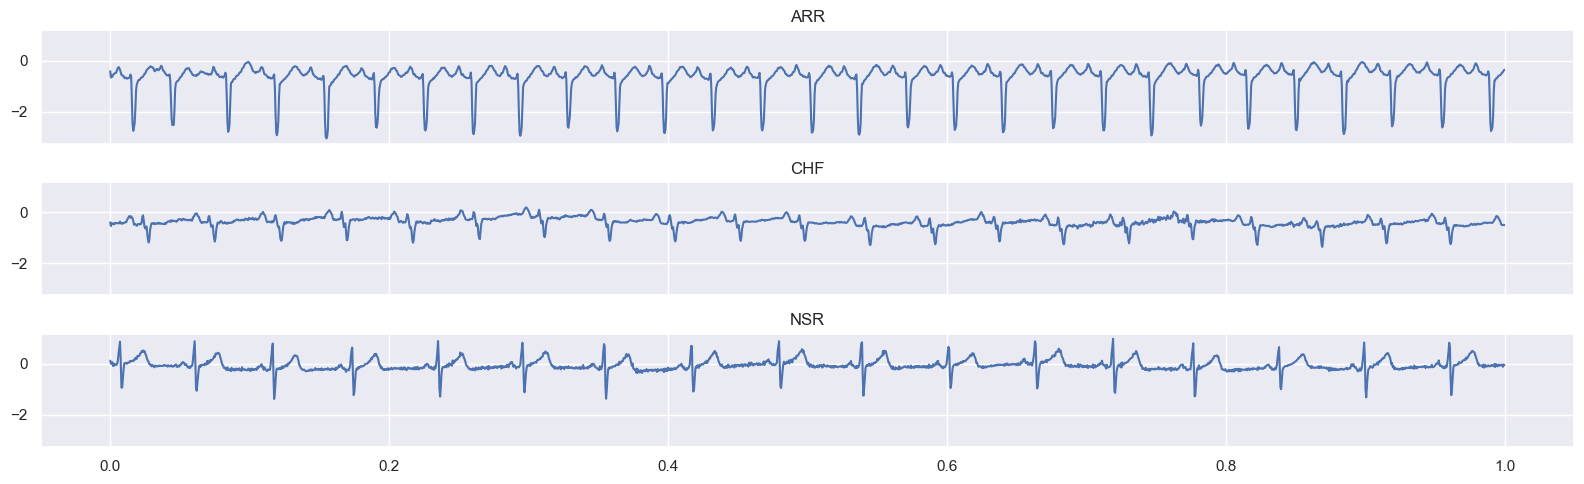

In [3]:
tot = 2000

fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(16, 5))

for i, t in enumerate(["ARR", "CHF", "NSR"]):
  samples = df[target == t].sample(1, random_state=42).values[0, :tot]
  axs[i].plot(np.arange(len(samples)) / tot, samples, label="ARR")
  axs[i].set_title(t)

plt.tight_layout()
plt.show()

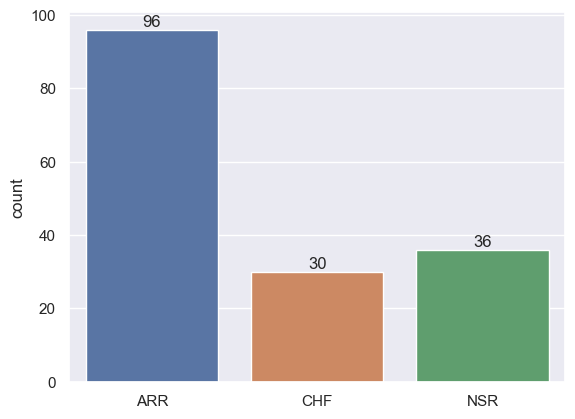

In [4]:
ax = sns.countplot(x=target)
ax.bar_label(*ax.containers)
plt.show()

## Pré-Processamento
---

In [5]:
le = LabelEncoder()
labels = le.fit_transform(target)

x_train, x_test, y_train, y_test = train_test_split(df, labels, stratify=labels, test_size=0.1, shuffle=True, random_state=42)

In [6]:
class_name, class_size = next(pd.Series(y_train).value_counts().items())

dfs, lbls = [], []
for label in np.unique(y_train):

  lbls += [label] * class_size
  if label == class_name:
    dfs += [x_train[y_train == label]]
    continue

  dfs += [resample(x_train[y_train == label], n_samples=class_size, replace=True, random_state=42)]

x_train = pd.concat(dfs)
y_train = lbls

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1, shuffle=True, random_state=42)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

datasets = [(x_train, y_train), (x_val, y_val), (x_test, y_test)]

print("Qty. Train:", len(x_train))
print("Qty. Validation:", len(x_val))
print("Qty. Test:", len(x_test))

Qty. Train: 232
Qty. Validation: 26
Qty. Test: 17


In [8]:
train_ds, val_ds, test_ds = [TensorDataset(torch.from_numpy(x).float(), torch.tensor(y)) for x, y in datasets]

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=True, num_workers=4)

## CNN
___

In [9]:
class ConvNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),

            nn.Conv1d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),

            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),

            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),

            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )

        self.linear = nn.Sequential(
            nn.Linear(262144, 500),
            nn.LeakyReLU(inplace=True),
            nn.Linear(500, n_classes)            
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.model(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = self.linear(x)
        return x

## Treinamento
---

In [49]:
# device = torch.device("cpu")
device = torch.device("mps")

net = ConvNet(3)
net.to(device)

# optimizer = Adam(net.parameters(), lr=0.001)
optimizer = AdamW(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 1

In [50]:
val_x, val_y = val_ds.tensors
val_x = val_x.to(device)

for epoch in range(1, epochs + 1):
    print('-' * 20)
    print(f' Epoch {epoch}/{epochs}')
    print('-' * 20)

    net.train()
    running_loss = 0.0
    running_corrects = 0
    
    for step, (x, y) in enumerate(train_dl, start=1):
        optimizer.zero_grad()

        x, y = x.to(device), y.to(device)
        logits = net(x)
        loss = criterion(logits, y)
        _, preds = torch.max(logits, 1)

        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * x.size(0)
        running_corrects += torch.sum(preds == y)

        epoch_loss = running_loss / len(train_dl)
        epoch_acc = running_corrects.float() / len(train_ds)

        print(f" Step[{step}/{len(train_dl)}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    
    with torch.no_grad():
        net.eval()
        result = net(val_x)
        result = result.argmax(1)
        acc_val = (result.cpu() == val_y).float().cpu().mean().item()
        net.train()
    
    print(f"Val Acc: {acc_val:.4f}")

--------------------
 Epoch 1/1
--------------------
 Step[1/8] Loss: 4.3883 Acc: 0.0603
 Step[2/8] Loss: 66.8964 Acc: 0.1034
 Step[3/8] Loss: 129.2313 Acc: 0.1595
 Step[4/8] Loss: 159.8541 Acc: 0.2112
 Step[5/8] Loss: 178.4245 Acc: 0.2629
 Step[6/8] Loss: 193.2971 Acc: 0.3147
 Step[7/8] Loss: 201.2510 Acc: 0.3664
 Step[8/8] Loss: 207.3106 Acc: 0.3664
Val Acc: 0.3077


In [12]:
# Save Model
# torch.save(net.state_dict(), "net.pt")

## Inferência
---

In [13]:
net2 = ConvNet(3)
net2.load_state_dict(torch.load("net.pt"))
net2.eval()

with torch.no_grad():
  x_train, y_train = train_ds.tensors
  result_train = net2(x_train)
  y_pred_train = result_train.argmax(1).cpu() 
  acc_train = (y_pred_train == y_train).float().mean().item()

  x_val, y_val = val_ds.tensors
  result_val = net2(x_val)
  y_pred_val = result_val.argmax(1).cpu() 
  acc_val = (y_pred_val == y_val).float().mean().item()

  x_test, y_test = test_ds.tensors
  result_test = net2(x_test)
  y_pred_test = result_test.argmax(1).cpu() 
  acc_test = (y_pred_test == y_test).float().mean().item()

print(f"Acc. Train:       {acc_train:.4f}")
print(f"Acc. Validation:  {acc_val:.4f}")
print(f"Acc. test:        {acc_test:.4f}")

Acc. Train:       0.9741
Acc. Validation:  1.0000
Acc. test:        0.8824


In [22]:
print(classification_report(y_true=y_test,y_pred=y_pred_test, target_names=le.classes_))
print('-' * 60)
print(f"F1 Score: {f1_score(y_test, y_pred_test, average='micro'):.2f}")
print(f"AUC Score (OvR): {roc_auc_score(y_test, F.softmax(result_test, dim=1), multi_class='ovr')}")

              precision    recall  f1-score   support

         ARR       1.00      0.80      0.89        10
         CHF       1.00      1.00      1.00         3
         NSR       0.67      1.00      0.80         4

    accuracy                           0.88        17
   macro avg       0.89      0.93      0.90        17
weighted avg       0.92      0.88      0.89        17

------------------------------------------------------------
F1 Score: 0.88
AUC Score (OvR): 1.0


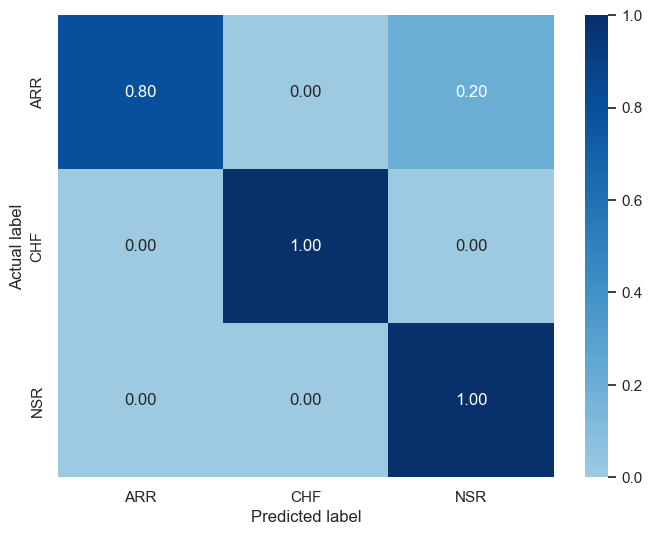

In [29]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot()

cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test, normalize="true")
sns.heatmap(cm, xticklabels=le.classes_, yticklabels=le.classes_, ax=ax, annot=True, cmap="Blues", center=0.2, fmt='.2f')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()